In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
df = pd.read_csv("data.csv")
df.drop(columns = ["SYM_ROOT"], inplace = True)
df.columns = ["Date", "Symbol", "Close", "Open", "Low", "High", "Avg", "Vol", "Intraday Volatility", "Variance Ratio (5 min)"]
df.isnull().sum()

Date                      0
Symbol                    0
Close                     0
Open                      0
Low                       0
High                      0
Avg                       0
Vol                       0
Intraday Volatility       0
Variance Ratio (5 min)    0
dtype: int64

In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace = True)
df.head()

,Symbol,Close,Open,Low,High,Avg,Vol,Intraday Volatility,Variance Ratio (5 min)
Date,,,,,,,,,
2023-01-03,AAPL,125.07,130.21,124.1667,130.9100,125.923384,106379013,3.192253e-07,0.013734
2023-01-04,AAPL,126.36,127.00,125.0700,140.2858,126.696887,84137393,1.321653e-07,0.326190
2023-01-05,AAPL,125.02,127.07,124.7500,129.7800,126.182508,77229825,2.759356e-07,0.148394
2023-01-06,AAPL,129.62,126.00,124.5100,142.9100,127.957889,82430488,8.851936e-08,0.378660
2023-01-09,AAPL,130.15,130.53,125.0200,133.4188,131.741920,67370452,6.345609e-07,0.261523


In [5]:
df["Realized Variance"]  = df["Intraday Volatility"] * 10_000
df["Log Return"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna(subset=["Log Return", "Realized Variance"])
thresh = 0.5
df = df[df["Log Return"].abs() <= thresh]

In [6]:
tickers = ["AAPL", "MSFT", "TSLA", "DIA", "QQQ", "SPY"]
dfs = {
    "AAPL": df[df["Symbol"] == "AAPL"],
    "MSFT": df[df["Symbol"] == "MSFT"],
    "TSLA": df[df["Symbol"] == "TSLA"],
    "DIA": df[df["Symbol"] == "DIA"],
    "QQQ": df[df["Symbol"] == "QQQ"],
    "SPY": df[df["Symbol"] == "SPY"]
}


AAPL fitted:
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.6371e-06  7.732e-09    470.370      0.000  [3.622e-06,3.652e-06]
alpha[1]       0.0100  1.011e-02      0.989      0.323 [-9.815e-03,2.982e-02]
beta[1]        0.9700  9.032e-03    107.400      0.000      [  0.952,  0.988]


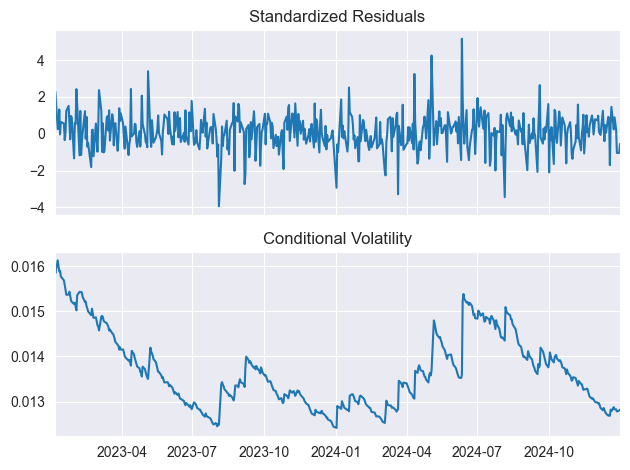


MSFT fitted:
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.0972e-06  9.628e-09    425.543      0.000  [4.078e-06,4.116e-06]
alpha[1]       0.0100  3.720e-02      0.269      0.788 [-6.292e-02,8.292e-02]
beta[1]        0.9700  2.955e-02     32.829 2.303e-236      [  0.912,  1.028]


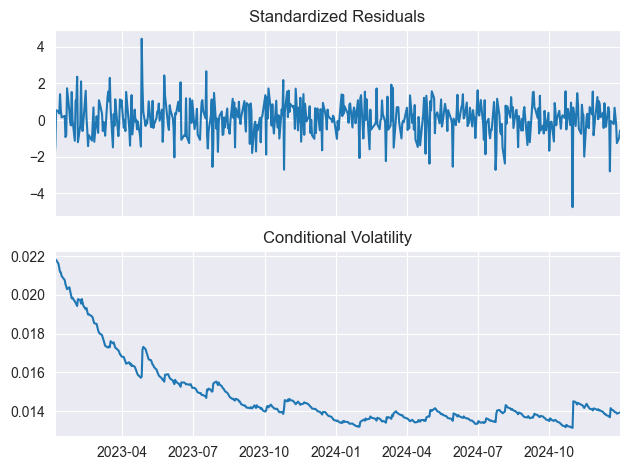


TSLA fitted:
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.6359e-05  4.362e-06      6.043  1.513e-09  [1.781e-05,3.491e-05]
alpha[1]       0.0112  1.063e-02      1.053      0.292 [-9.635e-03,3.202e-02]
beta[1]        0.9672  6.335e-03    152.677      0.000      [  0.955,  0.980]


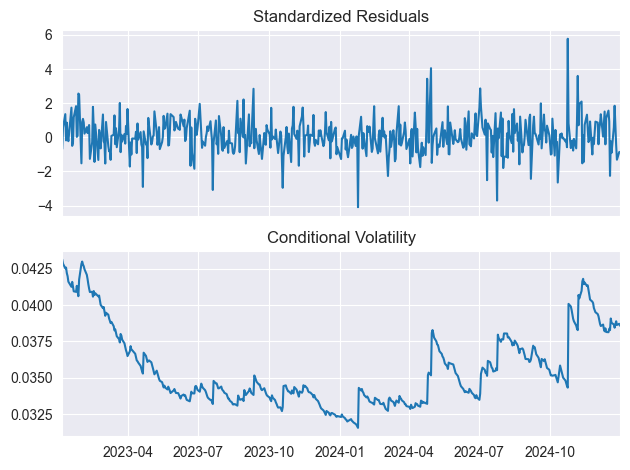


DIA fitted:
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.0365e-06  4.439e-09    233.485      0.000  [1.028e-06,1.045e-06]
alpha[1]       0.0100  2.855e-02      0.350      0.726 [-4.596e-02,6.596e-02]
beta[1]        0.9700  2.418e-02     40.114      0.000      [  0.923,  1.017]


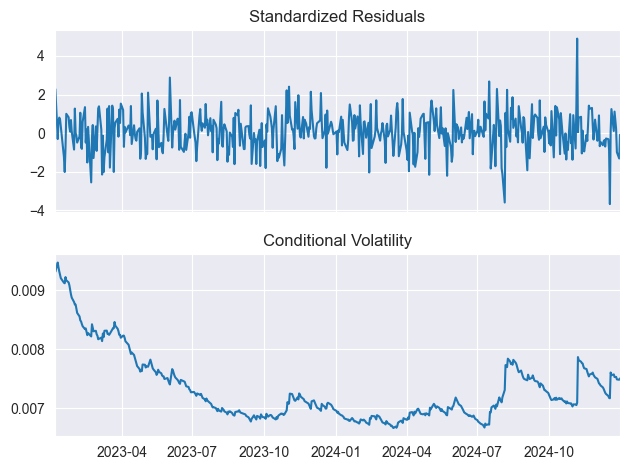


QQQ fitted:
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.2911e-05  1.085e-07    119.045      0.000 [1.270e-05,1.312e-05]
alpha[1]       0.0500  2.808e-02      1.781  7.499e-02  [-5.039e-03,  0.105]
beta[1]        0.8500  2.377e-02     35.762 4.346e-280     [  0.803,  0.897]


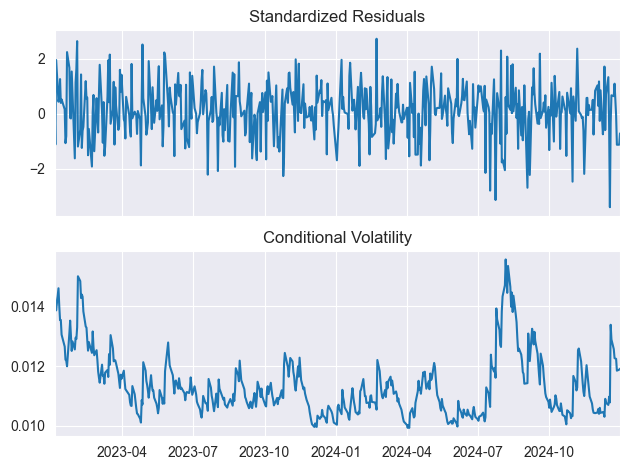


SPY fitted:
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.8147e-06  2.100e-09   2768.658      0.000 [5.811e-06,5.819e-06]
alpha[1]       0.0629  2.986e-02      2.105  3.533e-02   [4.319e-03,  0.121]
beta[1]        0.8496  2.849e-02     29.816 2.410e-195     [  0.794,  0.905]


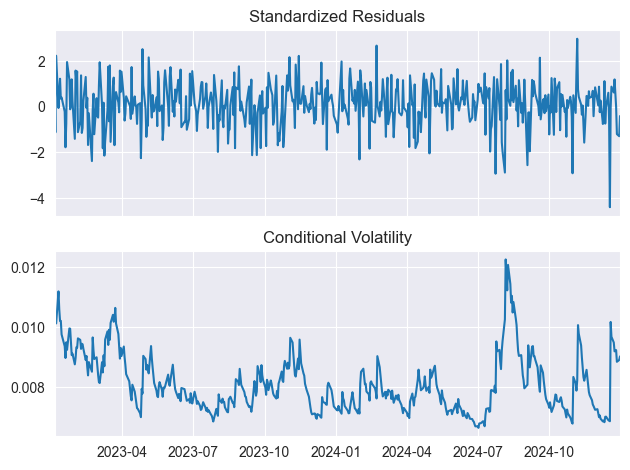

In [7]:
from arch import arch_model

garch_results   = {}     # save full result objects
garch_variances = {}     # save conditional variance series (in-sample)
garch_forecasts = {}     # save 1-day-ahead forecasts (out-of-sample)

for ticker, sub in dfs.items():
    # 1. make returns
    r = np.log(sub["Close"]).diff().dropna()        # daily log-return

    # 2. build & fit GARCH(1,1) with Student-t errors and zero mean
    am = arch_model(r, mean='Zero', vol='Garch', p=1, q=1,
                    dist='StudentsT', rescale=False)
    res = am.fit(disp="off")
    garch_results[ticker]   = res
    garch_variances[ticker] = res.conditional_volatility ** 2   # h_t
    print(f"\n{ticker} fitted:")
    print(res.summary().tables[1])                 # parameter table only

    # 3. quick plot (optional: comment out if you don’t need visuals now)
    fig = res.plot()
    fig.tight_layout()
    plt.show()

    # 4. 1-day-ahead forecast for entire sample (rolling)
    #    horizon=1 gives you next-day variance at every point
    f = res.forecast(horizon=1, start=0, reindex=True, align="target")
    garch_forecasts[ticker] = f.variance.iloc[:, 0]


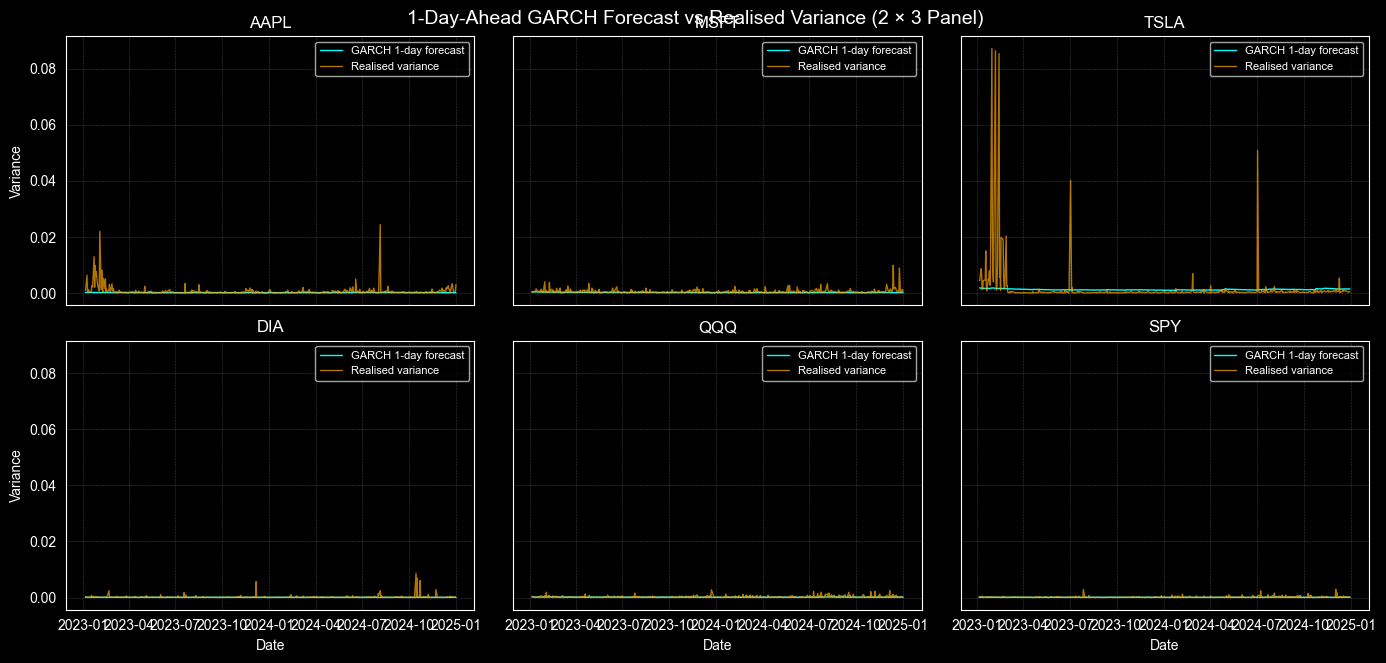

In [8]:
plt.style.use("dark_background")
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=True)
axes = axes.ravel()

for k, tkr in enumerate(tickers):
    rv  = dfs[tkr]["Realized Variance"]
    h_t = garch_forecasts[tkr]                    # already aligned (target)

    joined = pd.concat({"h": h_t, "rv": rv}, axis=1).dropna()

    ax = axes[k]
    ax.plot(joined.index, joined["h"],  color="cyan",   lw=1.0,
            label="GARCH 1-day forecast")
    ax.plot(joined.index, joined["rv"], color="orange", lw=1.0,
            label="Realised variance", alpha=0.7)

    ax.set_title(tkr)
    ax.grid(alpha=0.25, ls="--", lw=0.4)
    if k % 3 == 0:
        ax.set_ylabel("Variance")
    if k >= 3:
        ax.set_xlabel("Date")
    ax.legend(fontsize=8)

fig.suptitle("1-Day-Ahead GARCH Forecast vs Realised Variance (2 × 3 Panel)",
             y=0.94, fontsize=14)
fig.tight_layout()
plt.show()

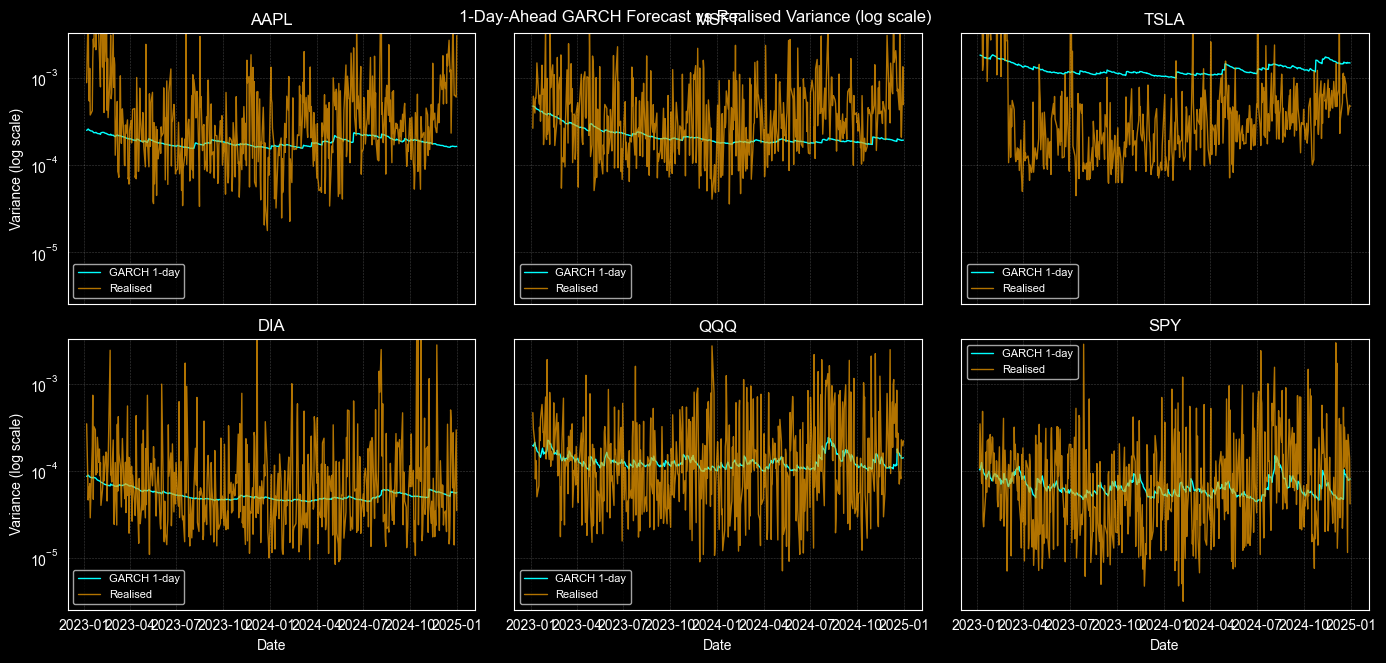

In [9]:
plt.style.use("dark_background")
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=True)
axes = axes.ravel()

for k, tkr in enumerate(tickers):
    rv  = dfs[tkr]["Realized Variance"]
    h   = garch_forecasts[tkr]            # already aligned (target)
    joined = pd.concat({"h": h, "rv": rv}, axis=1).dropna()

    ax = axes[k]
    ax.set_yscale("log")                                # ← key change
    ax.plot(joined.index, joined["h"],  color="cyan",   lw=1, label="GARCH 1-day")
    ax.plot(joined.index, joined["rv"], color="orange", lw=1, label="Realised", alpha=0.7)

    # Keep the full range but add small padding
    ax.set_ylim(joined.min().min()*0.8, joined.max().max()*1.1)

    ax.set_title(tkr)
    ax.grid(alpha=0.25, ls="--", lw=0.4)
    if k % 3 == 0:
        ax.set_ylabel("Variance (log scale)")
    if k >= 3:
        ax.set_xlabel("Date")
    ax.legend(fontsize=8)

fig.suptitle("1-Day-Ahead GARCH Forecast vs Realised Variance (log scale)", y=0.94)
fig.tight_layout()
plt.show()

In [10]:
from statsmodels.stats.diagnostic import acorr_ljungbox

n_out = 250

rows = []
for tkr in tickers:
    # align forecast & actual
    h = garch_forecasts[tkr]
    rv = dfs[tkr]["Realized Variance"]
    df_ = pd.concat({"h": h, "rv": rv}, axis=1).dropna()

    # split in-sample / out-of-sample
    insamp = df_.iloc[:-n_out]
    oos    = df_.iloc[-n_out:]

    # 1. In-sample fit
    res   = garch_results[tkr]
    llf   = res.loglikelihood

    # standardized residuals
    std_resid = res.resid / res.conditional_volatility

    # Ljung–Box on resid & resid^2 (lag=10)
    lb1 = acorr_ljungbox(std_resid, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    lb2 = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)["lb_pvalue"].iloc[0]

    # 2. Out-of-sample loss
    h_test  = oos["h"]
    rv_test = oos["rv"]

    mse   = ((h_test - rv_test)**2).mean()
    qlike = (rv_test / h_test - np.log(rv_test / h_test) - 1).mean()

    rows.append({
        "Ticker":       tkr,
        "LLF":          llf,
        "LB(resid)":    lb1,
        "LB(resid^2)":  lb2,
        "MSE(oos)":     mse,
        "QLIKE(oos)":   qlike,
    })

metrics_df = pd.DataFrame(rows).set_index("Ticker")
metrics_df.round(4)

,LLF,LB(resid),LB(resid^2),MSE(oos),QLIKE(oos)
Ticker,,,,,
AAPL,1464.3209,0.6147,0.8021,0.0,1.6114
MSFT,1435.9758,0.4822,0.9444,0.0,1.5369
TSLA,971.3526,0.5091,0.0057,0.0,0.8142
DIA,1767.2999,0.8687,0.9738,0.0,3.1446
QQQ,1538.6038,0.6143,0.1736,0.0,1.3341
SPY,1708.0461,0.7128,0.8741,0.0,2.1875


In [11]:
metrics_df["MSE(oos)"].round(8)

Ticker
AAPL    2.800000e-06
MSFT    1.120000e-06
TSLA    1.087000e-05
DIA     7.200000e-07
QQQ     2.100000e-07
SPY     1.500000e-07
Name: MSE(oos), dtype: float64